# Residential Building Demand Flexibility Modeling

Keywords: residential building, demand flexibility, thermostatically controlled loads (TCLs)

This notebook demonstrates the use of Python library Pandas and Numpy to develop a set of models of thermostatically controlled loads (TCLs).

# Thermostatically Controlled Loads (TCLs) Model
This notebook demonstrates the development of thermostatically controlled loads, including air-conditioners, refrigerators, and electric water heaters.

In [1]:
from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import csv
import datetime


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In order to model the demand response potential of load aggregations in residential buildings, first we will consider individual load models. Specifically, we focus our attention on thermostatically controlled loads (TCLs). TCLs such as refrigerators, water heaters and heating ventilation anda air conditioning (HVAC) systems are good candidates for demand side flexibility due to several factors: (i) they can be modeled using physics based models, (ii) they can be interrupted without any hinderance to their end-users, (iii) most of them are available to control signals 24/7. We will use a hybrid two state model to capture individual dynamics of each TCL \cite{Callaway,Kara,Mathieu}. Using these models, we will systematically derive the demand response flexibility for each load when a demand response event is initiated by thermostatic set-point adjustment. We will define flexibility of each load $i$ at any given time step $t$ for a set-point change of $\gamma$ as $f_{i,t}^{\gamma}$. 

The individual hybrid model that captures the underlying thermal dynamics of each TCL is given as follows:

$\theta_{i,t+1}=\alpha_i \theta_{i,t}+ (1-\alpha_i)(\theta^a_{i,t}-m_{i,t}\theta^g_{i})+\epsilon_{i,t}$

where $\theta_{i,t}$ is the interior temperature, $\theta^a_{i,t}$ is the ambient temperature at time $t$,$\theta^g_{i}$ is the heat gain, $m_{i,t}$ is a switch parameter representing ON/OFF state of the TCL and $\alpha$ is a parameter that captures the termal parameters of each TCL as follows:

$\alpha{i}=e^{-h /{C_iR_i}}$

where R_i and C_i are thermal resistance and capacitance respectively.
At any given point in time $t$, a TCL's operation can be interrupted by a set-point adjustment. When used to trigger demand response events, set-point adjustments results in TCLs switching OFF due to the change in thermostatic control bounds governing its interior temperature. Once the TCL is switched OFF, it remains OFF untill the interior temperature reaches the new thermostatic control bound that triggers switching from OFF to ON. To formalize this concept, let us define $\theta^s_{i,t}$ as the set-point for TCL $i$ at time $t$ and $\delta$ as the deadband width of the $i$th TCLs thermostatic bound. Due to a set-point adjustment of $\gamma$, $\theta^s_{i,t+1}$ can be defined as follows:

$\theta^s_{i,t+1}=\theta^s_{i,t} + \gamma$

Using the equation for individual load dynamics, one can define the $f_{i,t}^{\gamma}$ as the time that each TCL would take to switch back $ON$ if it were to be $OFF$ at any given time step $t$. For every time step $t$ one can estimate $f_{i,t}^{\gamma}$ for different $\gamma$ values. For cooling loads, $f_{i,t}^{\gamma}$ can be defined as:

$f_{i,t}^{\gamma}=-R_iC_i \ln(\frac{\theta^s_{i,t} + \gamma + \delta/2 - \theta^a_{i,t}}{\theta_{i,t}-\theta^a_{i,t}})$

Similarly, for cooling loads, the time that the TCL would take to switch back OFF when it was ON can be calculated as:

$f_{i,t}^{\gamma}=-R_iC_i \ln(\frac{\theta^s_{i} + \gamma - \delta/2 - \theta^a_{i} + P_{i}R_{i}}{\theta_{i}-\theta^a_{i}+ P_{i}R_{i}})$

Using this definition and parameters obtained from the literature on heterogenous load characteristics, we can simulate a population of TCLs composed of individual models in a bottom up fashion. 




In [2]:
#Parameters for individual TCLs from Rongxin

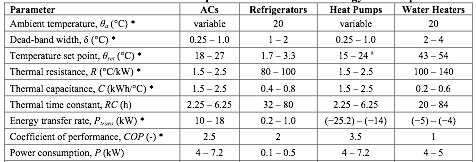

In [3]:
from IPython.display import Image 
Image(filename='data/chapter3/TCL_parameters.png')

In [4]:
#Let's define a class for each TCL
def get_t_off(R,C,setpoint,deadbandwidth,ambient,current,gamma=0,cooling=True):
    if current==ambient:
        t_off=24
    else:
        if cooling==True:
            t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-ambient)/(current-ambient))
        else:
            t_off=-1*R*C*np.log((setpoint+gamma-deadbandwidth/2-ambient)/(current-ambient))
    if t_off<0:
        t_off=np.nan
    return t_off
 
class Airconditioner(object):
    """
    A refrigerator class 

    """
    class_counter= 0
    def __init__(self, timestep,ambient_temp=20,cooling=True,err_sigma=0.01):
        
        """Return a Customer object whose name is *name* and starting
        balance is *balance*."""
        self.type='Airconditioner'
        Airconditioner.class_counter +=1
        self.id='AC'+str(Airconditioner.class_counter)
        self.cooling=cooling
        self.timestep = timestep #Has to be in hours        
        self.resistance= np.random.uniform(1.5,2.5,1)[0]
        self.capacitance= np.random.uniform(1.5,2.5,1)[0]
        self.power=np.random.uniform(4,7.2,1)[0]
        self.cop=2.5
        self.status=np.random.random_integers(0,1,1)[0]
        self.coolingpower=self.power*self.cop
        self.deadbandwidth=np.random.uniform(0.25,1,1)[0]       
        self.setpoint=np.random.uniform(18,27,1)[0]        
        self.interior_temp=np.random.uniform(self.setpoint-self.deadbandwidth/2,self.setpoint+self.deadbandwidth/2,1)[0]
        self.ambient_temp=ambient_temp
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)
        self.toff_1=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,1,self.cooling)
        self.toff_2=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,2,self.cooling)
        self.toff_3=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,3,self.cooling)

        self.err_sigma=err_sigma
        
        if self.cooling:
            self.gain=self.coolingpower*self.resistance
        else:
            self.gain=-1*self.coolingpower*self.resistance

        self.setpoint_DR=self.setpoint 
        self.interior_temp_DR=self.interior_temp
        self.status_DR=self.status
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]
       
    def next_interior(self):
        """Return the next timestep interior temperature"""
        #Implement thermostatic action:
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]
        if self.cooling:
            if self.ambient_temp>self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=0
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=1
            else:
                self.status=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=1
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=0
            else:
                self.status=0
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp=self.interior_temp*alpha+(1-alpha)*(self.ambient_temp-(self.status*self.gain))+self.curTempNoise


    def get_toff(self):
        """Return t_off given gamma"""
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)
        self.toff_1=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,1,self.cooling)
        self.toff_2=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,2,self.cooling)
        self.toff_3=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,3,self.cooling)

    def changeDRSetPoint(self,newSetPoint):
        """Assign a DR setpoint"""
        self.setpoint_DR=newSetPoint
        
    def next_interior_DR(self):
        """Return the next timestep interior temperature"""
        #Implement thermostatic action:
        if self.cooling:
            if self.ambient_temp>self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=0
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=1
            else:
                self.status_DR=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=1
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=0
            else:
                self.status_DR=0

              
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp_DR=self.interior_temp_DR*alpha+(1-alpha)*(self.ambient_temp-(self.status_DR*self.gain))+self.curTempNoise#+np.random.normal(0, self.err_sigma, 1)[0]

class Refrigerator(object):
    """
    A refrigerator class 

    """
    class_counter= 0
    def __init__(self, timestep,ambient_temp=20,cooling=True,err_sigma=0.01):
        
        """Return a Customer object whose name is *name* and starting
        balance is *balance*."""
        self.type='Refrigerator'
        Refrigerator.class_counter +=1
        self.id='REF'+str(Refrigerator.class_counter)
        self.cooling=cooling
        self.timestep = timestep #Has to be in hours
        self.resistance= np.random.uniform(80,100,1)[0]
        self.capacitance= np.random.uniform(0.4,0.8,1)[0]
        self.power=np.random.uniform(0.1,0.5,1)[0]
        self.cop=2
        self.status=np.random.random_integers(0,1,1)[0]
        self.coolingpower=self.power*self.cop
        self.deadbandwidth=np.random.uniform(1,2,1)[0]
        self.setpoint=np.random.uniform(1.7,3.3,1)[0]
        self.interior_temp=np.random.uniform(self.setpoint-self.deadbandwidth/2,self.setpoint+self.deadbandwidth/2,1)[0]
        self.ambient_temp=ambient_temp
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)
        self.toff_1=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,1,self.cooling)
        self.toff_2=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,2,self.cooling)
        self.toff_3=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,2,self.cooling)
        self.err_sigma=err_sigma
        
        if self.cooling:
            self.gain=self.coolingpower*self.resistance
        else:
            self.gain=-1*self.coolingpower*self.resistance

        self.setpoint_DR=self.setpoint 
        self.interior_temp_DR=self.interior_temp
        self.status_DR=self.status
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]

    def next_interior(self):
        """Return the next timestep interior temperature"""
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]
        if self.cooling:
            if self.ambient_temp>self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=0
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=1
            else:
                self.status=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=1
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=0
            else:
                self.status=0
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp=self.interior_temp*alpha+(1-alpha)*(self.ambient_temp-(self.status*self.gain))+self.curTempNoise

    def get_toff(self):
        """Return t_off given gamma"""
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)
        self.toff_1=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,1,self.cooling)
        self.toff_2=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,2,self.cooling)
    
    def changeDRSetPoint(self,newSetPoint):
        """Assign a DR setpoint"""
        self.setpoint_DR=newSetPoint
        
    def next_interior_DR(self):
        """Return the next timestep interior temperature"""
        #Implement thermostatic action:
        if self.cooling:
            if self.ambient_temp>self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=0
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=1
            else:
                self.status_DR=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=1
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=0
            else:
                self.status_DR=0

              
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp_DR=self.interior_temp_DR*alpha+(1-alpha)*(self.ambient_temp-(self.status_DR*self.gain))+self.curTempNoise

class Waterheater(object):
    """
    A Waterheater class 

    """
    class_counter= 0
    def __init__(self, timestep,ambient_temp=20,cooling=False,err_sigma=0.01):
        
        """Return a Customer object whose name is *name* and starting
        balance is *balance*."""
        self.type='Waterheater'
        Waterheater.class_counter +=1
        self.id='WH'+str(Waterheater.class_counter)
        self.cooling=cooling
        self.timestep = timestep #Has to be in hours
        self.resistance= np.random.uniform(100,140,1)[0]
        self.capacitance= np.random.uniform(0.2,0.6,1)[0]
        self.power=np.random.uniform(4,5,1)[0]
        self.cop=1
        self.status=np.random.random_integers(0,1,1)[0]

        self.coolingpower=self.power*self.cop
        self.deadbandwidth=np.random.uniform(2,4,1)[0]
        self.setpoint=np.random.uniform(43,54,1)[0]
        self.interior_temp=np.random.uniform(self.setpoint-self.deadbandwidth/2,self.setpoint+self.deadbandwidth/2,1)[0]
        self.ambient_temp=ambient_temp
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)
        self.toff_1=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,1,self.cooling)
        self.toff_2=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,2,self.cooling)
        self.err_sigma=err_sigma
        
        if self.cooling:
            self.gain=self.coolingpower*self.resistance
        else:
            self.gain=-1*self.coolingpower*self.resistance

        self.setpoint_DR=self.setpoint 
        self.interior_temp_DR=self.interior_temp
        self.status_DR=self.status
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]

    def next_interior(self):
        """Return the next timestep interior temperature"""
        #Implement thermostatic action:
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]
        if self.cooling:
            if self.ambient_temp>self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=0
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=1
            else:
                self.status=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=1
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=0
            else:
                self.status=0
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp=self.interior_temp*alpha+(1-alpha)*(self.ambient_temp-(self.status*self.gain))+self.curTempNoise


    def get_toff(self):
        """Return t_off given gamma"""
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)
        self.toff_1=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,-1,self.cooling)
        self.toff_2=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,-2,self.cooling)
    
    def changeDRSetPoint(self,newSetPoint):
        """Assign a DR setpoint"""
        self.setpoint_DR=newSetPoint
        
    def next_interior_DR(self):
        """Return the next timestep interior temperature"""
        #Implement thermostatic action:
        if self.cooling:
            if self.ambient_temp>self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=0
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=1
            else:
                self.status_DR=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=1
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=0
            else:
                self.status_DR=0

              
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp_DR=self.interior_temp_DR*alpha+(1-alpha)*(self.ambient_temp-(self.status_DR*self.gain))+self.curTempNoise


### SAMPLE SIMULATIONS OF AN INDIVIDUAL CLASS

In [5]:
wh=Waterheater(1/60)
ref=Refrigerator(1/60)

In [6]:
# JUST A SAMPLE SIMULATION OF A DR EVENT:
toff_ref=[]
toff_1_ref=[]
internal_temp_ref=[]
internal_temp_ref_DR=[]
ref_setpoint_DR=[]
ref_setpoint=[]
wh_setpoint_DR=[]
wh_setpoint=[]

power_ref=[]
power_ref_DR=[]

toff_wh=[]
toff_1_wh=[]
internal_temp_wh=[]
internal_temp_wh_DR=[]
power_wh=[]
power_wh_DR=[]

eventStartTimes=[6*60,18*60,30*60,42*60,60*60]
eventEndTimes=[elem+60 for elem in eventStartTimes]
duration=range(60*72)
for i in duration:
    
    if i in eventStartTimes:
            print('changing setpoint')
            ref.changeDRSetPoint(1-ref.setpoint)
            wh.changeDRSetPoint(wh.setpoint-1)

    if i in eventEndTimes:
            ref.changeDRSetPoint(ref.setpoint)
            wh.changeDRSetPoint(wh.setpoint)   
           
    ref.get_toff()
    ref.next_interior()
    ref.next_interior_DR()
    
    wh.get_toff()
    wh.next_interior()
    wh.next_interior_DR()
    
    internal_temp_ref.append(ref.interior_temp)
    internal_temp_ref_DR.append(ref.interior_temp_DR)
    toff_ref.append(ref.toff)
    power_ref.append(ref.power*ref.status)
    power_ref_DR.append(ref.power*ref.status_DR)
    toff_1_ref.append(ref.toff_1)
    ref_setpoint_DR.append(ref.setpoint_DR)
    ref_setpoint.append(ref.setpoint)
   
    internal_temp_wh.append(wh.interior_temp)
    internal_temp_wh_DR.append(wh.interior_temp_DR)
    toff_wh.append(wh.toff)
    power_wh.append(wh.power*wh.status)
    power_wh_DR.append(wh.power*wh.status_DR)    
    toff_1_wh.append(wh.toff_1)
    wh_setpoint_DR.append(wh.setpoint_DR)
    wh_setpoint.append(wh.setpoint)

changing setpoint
changing setpoint
changing setpoint
changing setpoint
changing setpoint


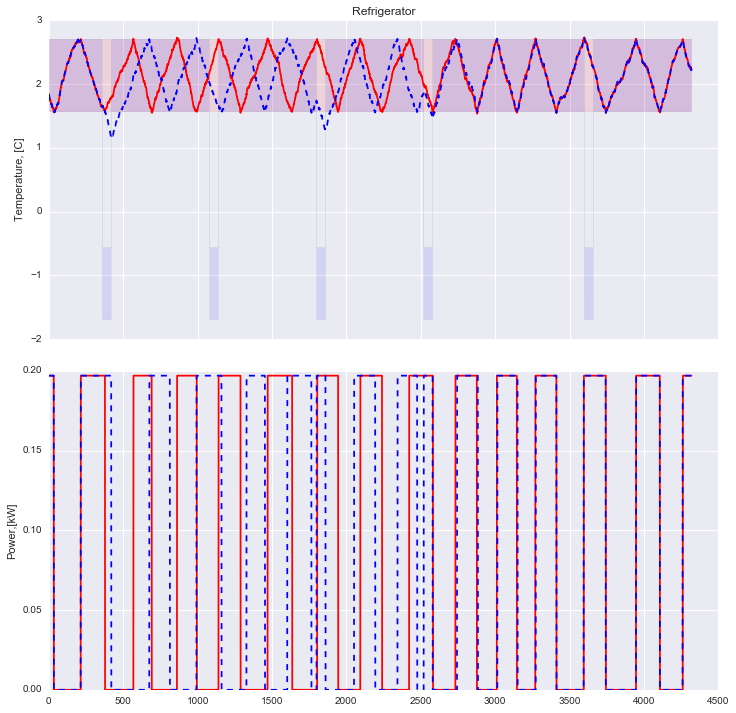

In [7]:
fig, axs = plt.subplots(2,1, figsize=(12, 12), facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .1, wspace=.001)

axs[0].set_title('Refrigerator')
axs[0].plot(internal_temp_ref,'r')
axs[0].plot(internal_temp_ref_DR,'--b')
axs[0].fill_between(duration,ref_setpoint-ref.deadbandwidth/2, ref_setpoint+ref.deadbandwidth/2,facecolor='red',alpha=0.1)
axs[0].fill_between(duration,ref_setpoint_DR-ref.deadbandwidth/2, ref_setpoint_DR+ref.deadbandwidth/2,facecolor='blue',alpha=0.1)

axs[0].set_ylabel('Temperature, [C]')

axs[1].plot(power_ref,'r')
axs[1].plot(power_ref_DR,'--b')
axs[1].set_ylabel('Power,[kW]')

fig.savefig('Sample_Refrigerator.png', dpi=200, format='png',bbox_inches='tight')
plt.show()

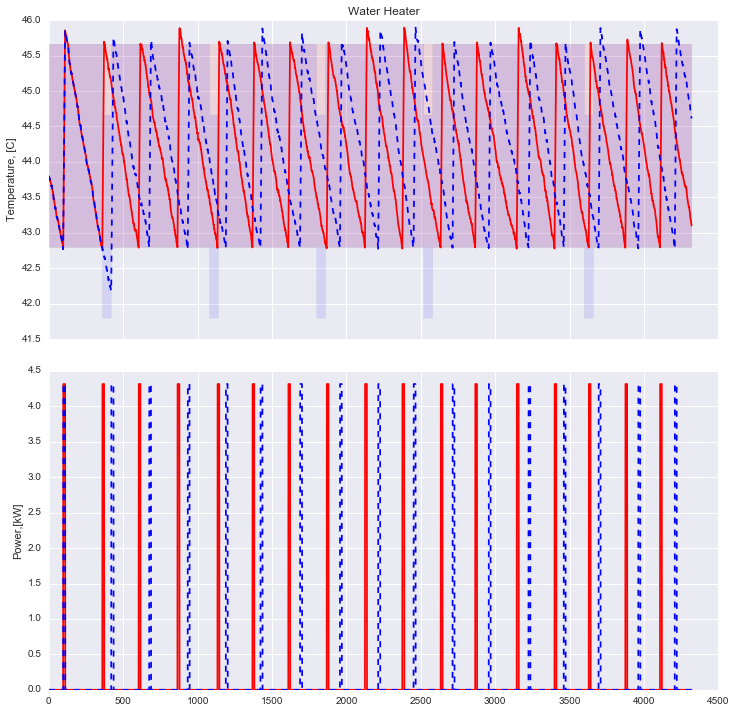

In [8]:
fig, axs = plt.subplots(2,1, figsize=(12, 12), facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .1, wspace=.001)

axs[0].set_title('Water Heater')
axs[0].plot(internal_temp_wh,'r')
axs[0].plot(internal_temp_wh_DR,'--b')
axs[0].fill_between(duration,wh_setpoint-wh.deadbandwidth/2, wh_setpoint+wh.deadbandwidth/2,facecolor='red',alpha=0.1)
axs[0].fill_between(duration,wh_setpoint_DR-wh.deadbandwidth/2, wh_setpoint_DR+wh.deadbandwidth/2,facecolor='blue',alpha=0.1)

axs[0].set_ylabel('Temperature, [C]')

axs[1].plot(power_wh,'r')
axs[1].plot(power_wh_DR,'--b')
axs[1].set_ylabel('Power,[kW]')

fig.savefig('Sample_Waterheater.png', dpi=200, format='png',bbox_inches='tight')
plt.show()

In [9]:
#Initialize individual TCLs
number_of_tcls=1000
step=2 #in minutes
timestep=step/60 #in hours
duration=3 #in hours
### KEEP THESE THE SAME


In [10]:
results=[]
setPointChanges=[1,2,3,-1,-2,-3]
duration=range(0,60*duration,step)
eventStartTimes=[1*60] # in minutes 
eventEndTimes=[elem+60 for elem in eventStartTimes]

for SetPointChange in setPointChanges:
    curDate=datetime.datetime(year=2015,month=1,day=1,hour=0,minute=0)
    list_of_tcls=[]
    # INITIALIZE A SET OF TCLs 
    for elem in range(number_of_tcls):
        list_of_tcls.append(Refrigerator(timestep))
        list_of_tcls.append(Waterheater(timestep))
        #list_of_tcls.append(Airconditioner(timestep,16))
    hr=0
    for i in duration:  
        if i in eventStartTimes:
            print('changing setpoint')
            for ref in list_of_tcls:
                ref.changeDRSetPoint(ref.setpoint+SetPointChange)

        if i in eventEndTimes:
            print('changing setpoint')
            for ref in list_of_tcls:
                ref.changeDRSetPoint(ref.setpoint)

        if i % 60 == 0:
            hr=hr+1
            print('Simulated '+str(hr)+' hours.')
        for ref in list_of_tcls:
            #ref.get_toff()
            ref.next_interior()
            ref.next_interior_DR()

            resDict={}
            resDict['InteriorTemp']=ref.interior_temp
            resDict['InternalTempDR']=ref.interior_temp_DR
            resDict['Resistance']=ref.resistance
            resDict['Capacitance']=ref.capacitance
            resDict['DeadBandWidth']=ref.deadbandwidth

            #toff_ref.append(ref.toff)
            resDict['CurrentPower']=ref.power*ref.status
            resDict['CurrentPowerDR']=ref.power*ref.status_DR
            resDict['DRPercent']=((ref.power*ref.status_DR)-(ref.power*ref.status))*100/ref.power #DR-Nominal
            resDict['RatedPower']=ref.power
            resDict['SetPoint']=ref.setpoint
            resDict['SetPointDR']=ref.setpoint_DR
            resDict['Type']=ref.type
            resDict['Id']=ref.id
            resDict['Minute']=i
            resDict['Date']=curDate
            resDict['SetPointChange']=SetPointChange
            results.append(resDict)
        curDate=curDate+datetime.timedelta(minutes=step)
results=pd.DataFrame(results)   

def getHour(row):
    return row['Date'].hour

results['Hour']=results.apply(getHour,axis=1)  

[ 20.37649625  25.87844796  24.51136933  24.28210523  21.59849719
  18.3634573   18.34757989  20.66588876  26.21080978  17.48703695
  17.78208448  21.1987007   18.82456159  20.42966075  24.83102234
  25.96189595  24.67297779  24.41770564  27.66886712  17.08099773
  21.06864147  26.03553125  19.46827345  19.13090438  18.41347044
  26.22412394  22.95591931  21.31483321  22.81241534  26.55431019
  26.86104052  18.53776406  17.51888015  27.23872558  18.95828305
  18.00179118  21.94698099  22.07128997  18.28011173  25.88698694
  21.33838257  17.90813732  21.89925588  21.42658414  25.27706136
  19.59056149  25.71096277  17.62289041  20.0803799   22.78294104
  17.27085406  26.95874618  18.91783594  20.92514397  26.69342692
  17.8574254   24.97496475  25.66102093  27.94754866  27.19051464
  17.68295671  20.72080537  26.39146102  25.61073424  22.41730958
  20.0497995   27.37548324  21.98494767  24.12821937  25.60328325
  26.34171048  19.65210269  21.98944842  17.98894265  21.50300607
  23.48892

KeyboardInterrupt: 

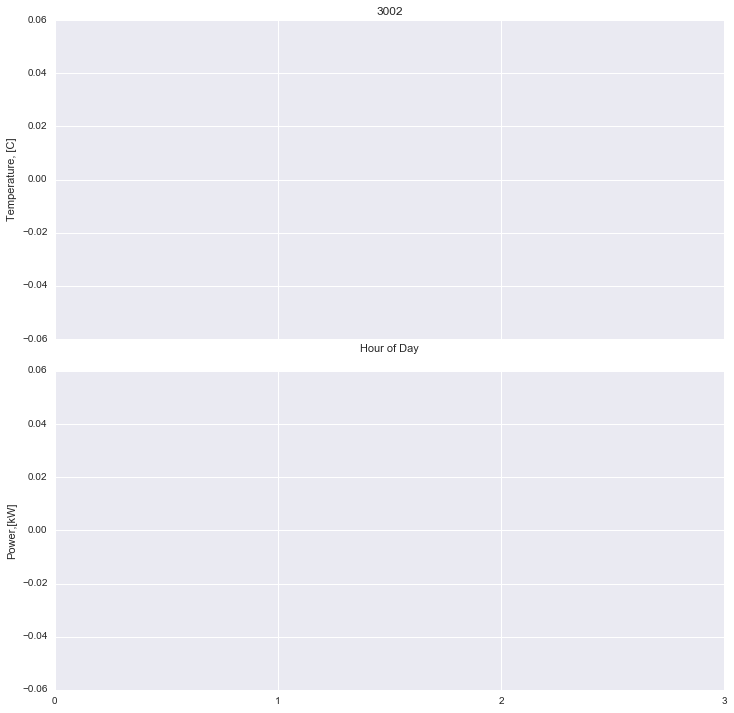

In [15]:
tclid=3002
subSample=results[results['Id']==tclid]
fig, axs = plt.subplots(2,1, figsize=(12, 12), facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .1, wspace=.001)

axs[0].set_title(tclid)
axs[0].plot(subSample['Minute']/60,subSample['InteriorTemp'],'r')
axs[0].plot(subSample['Minute']/60,subSample['InternalTempDR'],'--b')
axs[0].fill_between(subSample['Minute']/60,subSample['SetPoint']-subSample['DeadBandWidth']/2, subSample['SetPoint']+subSample['DeadBandWidth']/2,facecolor='red',alpha=0.1)
axs[0].fill_between(subSample['Minute']/60,subSample['SetPointDR']-subSample['DeadBandWidth']/2, subSample['SetPointDR']+subSample['DeadBandWidth']/2,facecolor='blue',alpha=0.1)

axs[0].set_ylabel('Temperature, [C]')

axs[1].plot(subSample['Minute']/60,subSample['CurrentPower'],'r')
axs[1].plot(subSample['Minute']/60,subSample['CurrentPowerDR'],'--b')
axs[1].set_ylabel('Power,[kW]')

axs[0].set_xlim([0,3])
axs[0].xaxis.set_ticks(np.arange(0, 4, 1))
axs[0].set_xlabel('Hour of Day')
fig.savefig('Unit'+str(tclid)+'.png', dpi=200, format='png',bbox_inches='tight')
plt.show()

In [16]:
def chunks(l,n):
    n = max(1, n)
    return [l[i:i + n] for i in range(0, len(l), n)]

Types=['Refrigerator','Waterheater']
cluster_sizes=[10,25,50,100,250,500]
GroupResultsList=[]
GroupResults=results[(results['Hour']==1)]
for SetPointChange in setPointChanges:
    for Type in Types:
        SubGroupResults=GroupResults[(GroupResults['Type']==Type) & (GroupResults['SetPointChange']==SetPointChange)]
        print(len(SubGroupResults))
        for n in cluster_sizes:
            listOfIds=chunks(SubGroupResults['Id'].unique(),n)
            ctr=0
            for k in listOfIds:
                SelectedGroupResults=SubGroupResults[SubGroupResults['Id'].isin(k)]
                AvePower=SelectedGroupResults.groupby(['Id','Hour','Resistance','Capacitance','DeadBandWidth'])['DRPercent','CurrentPower'].mean()
                AvePowerDF = AvePower.reset_index()
                SumDRPotential=AvePowerDF.groupby(['Hour'])['DRPercent','CurrentPower'].sum()
                #print(SumDRPotential)
                SumDRPotentialDF=SumDRPotential.reset_index()
                #print(SumDRPotential['PowerDiff'].values[0])
                GroupRes={}
                #print(SumDRPotentialDF)
                GroupRes['TotalDR']=SumDRPotentialDF['DRPercent'].values[0]#/SumDRPotentialDF['CurrentPower'].values[0]
                GroupRes['Type']=Type#/SumDRPotentialDF['CurrentPower'].values[0]
                GroupRes['SetPointChange']=SetPointChange#/SumDRPotentialDF['CurrentPower'].values[0]
                GroupRes['ClusterSize']=n
                GroupResultsList.append(GroupRes)
                #print('Done with '+str(ctr/len(listOfIds)))
                ctr=ctr+1
GroupResults=pd.DataFrame(GroupResultsList)


60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000


In [17]:
means=GroupResults.groupby(['Type','ClusterSize','SetPointChange'])['TotalDR'].mean()
stds=GroupResults.groupby(['Type','ClusterSize','SetPointChange'])['TotalDR'].std()

meansDF=pd.DataFrame(means).reset_index()
meansDF = meansDF.rename(columns={'TotalDR': 'TotalDRAVE'})

stdsDF=pd.DataFrame(stds).reset_index()
stdsDF=stdsDF.rename(columns={'TotalDR': 'TotalDRSTD'})

JoinedDF=pd.merge(stdsDF,meansDF, on=['Type','ClusterSize','SetPointChange'],how='left')





[1, 2, 3, -1, -2, -3]
plotting water heater
plotting water heater
plotting water heater
plotting water heater
plotting water heater
plotting water heater


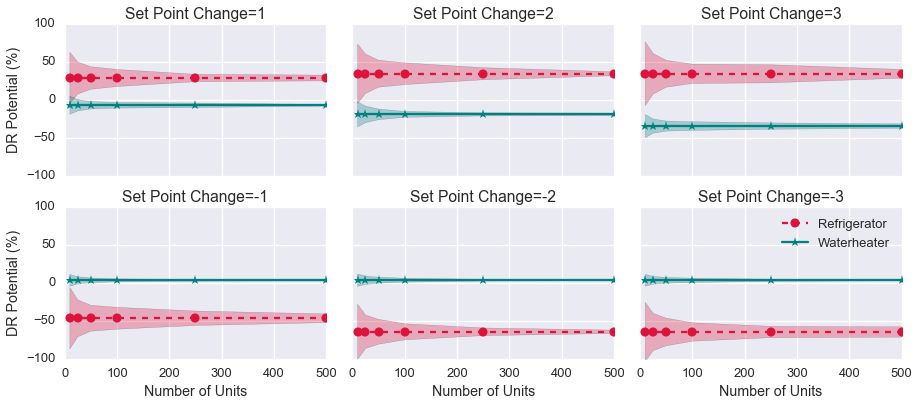

In [32]:
sns.set_context('talk')
fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k',sharex=True,sharey=True)
fig.subplots_adjust(hspace = .2, wspace=.1)

axs = axs.ravel()
i=0
print(setPointChanges)
for SetPointChange in setPointChanges:
    for Type in Types:
        joinedData=JoinedDF[(JoinedDF['SetPointChange']==SetPointChange) & (JoinedDF['Type']==Type)]
        joinedData=joinedData[joinedData['Type']==Type]
        if Type=='Refrigerator':
            axs[i].set_title('Set Point Change='+str(SetPointChange))
            axs[i].plot(joinedData['ClusterSize'], -1*joinedData['TotalDRAVE']/joinedData['ClusterSize'],'--o',color='crimson',label=Type)
            axs[i].fill_between(joinedData['ClusterSize'], -1*(joinedData['TotalDRAVE']+3*joinedData['TotalDRSTD'])/joinedData['ClusterSize'],-1*(joinedData['TotalDRAVE']-3*joinedData['TotalDRSTD'])/joinedData['ClusterSize'],facecolor='crimson',alpha=0.3)
            #axs.set_xscale("log")
            if ((i==0) | (i==3)):
                axs[i].set_ylabel("DR Potential (%)")
            if (i>2):
                axs[i].set_xlabel("Number of Units")
        if Type=='Waterheater':
            print('plotting water heater')
            axs[i].plot(joinedData['ClusterSize'], -1*joinedData['TotalDRAVE']/joinedData['ClusterSize'],'-*',color='teal',label=Type)
            axs[i].fill_between(joinedData['ClusterSize'], -1*(joinedData['TotalDRAVE']+3*joinedData['TotalDRSTD'])/joinedData['ClusterSize'],-1*(joinedData['TotalDRAVE']-3*joinedData['TotalDRSTD'])/joinedData['ClusterSize'],facecolor='teal',alpha=0.3)
            #axs.set_xscale("log")
            #axs[i].set_ylabel("DR Potential (%)")
            #axs[i].set_xlabel("Number of Units")
        if i==5:
            axs[i].legend()
        axs[i].set_ylim([-100,100])
    i=i+1  
fig.savefig('./RefWaterHeaterPotential.png', dpi=200, format='png')

## Uniform Sampling of Outside Air Temperature

In [19]:
#Initialize individual TCLs
number_of_tcls=500
step=2 #in minutes
timestep=step/60 #in hours
duration=2 #in hours
### KEEP THESE THE SAME


In [20]:
results=[]
setPointChanges=[1,2,3,-1,-2,-3]
duration=range(0,60*duration,step)
eventStartTimes=[1*60] # in minutes 
eventEndTimes=[elem+60 for elem in eventStartTimes]
AmbientTemps=np.random.uniform(17,28,50)
for ambientTemp in AmbientTemps:
    for SetPointChange in setPointChanges:
        curDate=datetime.datetime(year=2015,month=1,day=1,hour=0,minute=0)
        list_of_tcls=[]
        # INITIALIZE A SET OF TCLs 
        for elem in range(number_of_tcls):
            list_of_tcls.append(Refrigerator(timestep,ambient_temp=ambientTemp))
            list_of_tcls.append(Waterheater(timestep,ambient_temp=ambientTemp))
            #list_of_tcls.append(Airconditioner(timestep,16))
        hr=0
        for i in duration:  
            if i in eventStartTimes:
                print('changing setpoint')
                for ref in list_of_tcls:
                    ref.changeDRSetPoint(ref.setpoint+SetPointChange)

            if i in eventEndTimes:
                print('changing setpoint')
                for ref in list_of_tcls:
                    ref.changeDRSetPoint(ref.setpoint)

            if i % 60 == 0:
                hr=hr+1
                print('Simulated '+str(hr)+' hours.')
            for ref in list_of_tcls:
                #ref.get_toff()
                ref.next_interior()
                ref.next_interior_DR()

                resDict={}
                resDict['InteriorTemp']=ref.interior_temp
                resDict['InternalTempDR']=ref.interior_temp_DR
                resDict['Resistance']=ref.resistance
                resDict['Capacitance']=ref.capacitance
                resDict['DeadBandWidth']=ref.deadbandwidth

                #toff_ref.append(ref.toff)
                resDict['CurrentPower']=ref.power*ref.status
                resDict['CurrentPowerDR']=ref.power*ref.status_DR
                resDict['DRPercent']=((ref.power*ref.status_DR)-(ref.power*ref.status))*100/ref.power #DR-Nominal
                resDict['RatedPower']=ref.power
                resDict['SetPoint']=ref.setpoint
                resDict['SetPointDR']=ref.setpoint_DR
                resDict['Type']=ref.type
                resDict['Id']=ref.id
                resDict['Minute']=i
                resDict['Date']=curDate
                resDict['SetPointChange']=SetPointChange
                resDict['AmbientTemp']=ambientTemp

                results.append(resDict)
            curDate=curDate+datetime.timedelta(minutes=step)
results=pd.DataFrame(results)   

def getHour(row):
    return row['Date'].hour

results['Hour']=results.apply(getHour,axis=1)  

Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2

In [21]:
def chunks(l,n):
    n = max(1, n)
    return [l[i:i + n] for i in range(0, len(l), n)]

Types=['Refrigerator','Waterheater']
cluster_sizes=[500]
GroupResultsList=[]
GroupResults=results[(results['Hour']==1)]
for ambientTemp in AmbientTemps:
    for SetPointChange in setPointChanges:
        for Type in Types:
            SubGroupResults=GroupResults[(GroupResults['Type']==Type) & (GroupResults['SetPointChange']==SetPointChange)& (GroupResults['AmbientTemp']==ambientTemp)]
            #print(len(SubGroupResults))
            for n in cluster_sizes:
                listOfIds=chunks(SubGroupResults['Id'].unique(),n)
                ctr=0
                for k in listOfIds:
                    SelectedGroupResults=SubGroupResults[SubGroupResults['Id'].isin(k)]
                    AvePower=SelectedGroupResults.groupby(['Id','Hour','Resistance','Capacitance','DeadBandWidth'])['DRPercent','CurrentPower'].mean()
                    AvePowerDF = AvePower.reset_index()
                    SumDRPotential=AvePowerDF.groupby(['Hour'])['DRPercent','CurrentPower'].sum()
                    #print(SumDRPotential)
                    SumDRPotentialDF=SumDRPotential.reset_index()
                    #print(SumDRPotential['PowerDiff'].values[0])
                    GroupRes={}
                    #print(SumDRPotentialDF)
                    GroupRes['TotalDR']=SumDRPotentialDF['DRPercent'].values[0]#/SumDRPotentialDF['CurrentPower'].values[0]
                    GroupRes['Type']=Type#/SumDRPotentialDF['CurrentPower'].values[0]
                    GroupRes['SetPointChange']=SetPointChange#/SumDRPotentialDF['CurrentPower'].values[0]
                    GroupRes['ClusterSize']=n
                    GroupRes['AmbientTemp']=ambientTemp
                    GroupResultsList.append(GroupRes)
                    #print('Done with '+str(ctr/len(listOfIds)))
                    ctr=ctr+1
GroupResults=pd.DataFrame(GroupResultsList)


In [25]:
GroupResults.to_pickle('./GroupResultsofAmbientVarying.pkl')

This is the typeRefrigerator
Refrigerator&-34.25&1.01&0.87&0.06
This is the typeWaterheater
Waterheater&-30.08&0.16&0.64&0.02
This is the typeAC
AC&-18.94&0.30&0.48&0.02&-111.70&1.55&0.78&0.05&23.01&0.11&0.18&0.05


-c:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


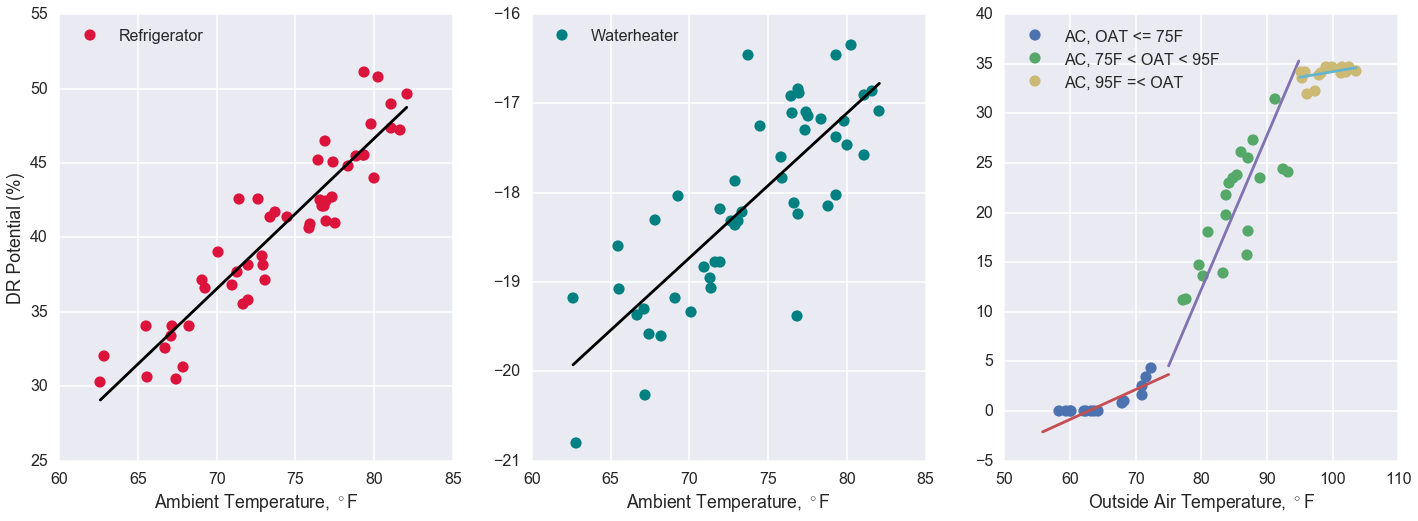

In [56]:
sns.set_context('poster')
def FFromCelsius(row):
    return row['AmbientTemp']*1.8+32
def GetDRPercent(row):
    return -1*row['TotalDR']/row['ClusterSize']

GroupResults['AmbientTempF']=GroupResults.apply(FFromCelsius,axis=1)
GroupResults['DRPercent']=GroupResults.apply(GetDRPercent,axis=1)

GroupResults2=GroupResults[GroupResults['SetPointChange']==2]
GroupResults2=GroupResults2[['AmbientTempF','DRPercent','Type']]
DRPercentHourlyOATResults=pd.read_pickle('ACSetPointOATMultiDay.pkl')
DRPercentHourlyOATResults['DRPercent']=DRPercentHourlyOATResults['DRPercent']*-1
DRPercentHourlyOATResults['AmbientTempF']=DRPercentHourlyOATResults.apply(FFromCelsius,axis=1)

FromACs=DRPercentHourlyOATResults[DRPercentHourlyOATResults['SetPointChange']==2]
FromACs['Type']='AC'
len(FromACs)
FromACs=FromACs[['AmbientTempF','DRPercent','Type']]

GroupResults2=pd.concat([FromACs,GroupResults2])

i=0
fig,axes=plt.subplots(1,3,figsize=[24,8])
Types=['Refrigerator','Waterheater','AC']

for typ in Types:
    print('This is the type'+typ)
    from scipy import stats
    DRPercentHourlyOATResults2Deg=GroupResults2[GroupResults2['Type']==typ]
    if i<2:
        x1 = DRPercentHourlyOATResults2Deg[['AmbientTempF','DRPercent']].AmbientTempF
        y1 = DRPercentHourlyOATResults2Deg[['AmbientTempF','DRPercent']].DRPercent

        z1 = np.polyfit(x1, y1, 1)
        p1 = np.poly1d(z1)
        xp1 = np.linspace(min(x1), max(x1), 100)
        slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
        z1_err = [r_value1**2, std_err1]
        r_err1 = abs(((x1 * slope1 + intercept1)-y1) / y1)
        #print(r_err1)
        if i==0:
            axes.ravel()[i].plot(x1, y1, 'o',color='crimson', label = typ)
            axes.ravel()[i].plot(xp1, p1(xp1), '-k')

            axes.ravel()[i].set_xlabel('Ambient Temperature, $^\circ$F')
            axes.ravel()[i].set_ylabel('DR Potential (%)')
            axes.ravel()[i].legend(loc='upper left')
        else:
            axes.ravel()[i].plot(x1, y1, 'o',color='teal', label = typ)
            axes.ravel()[i].plot(xp1, p1(xp1), '-k')

            axes.ravel()[i].set_xlabel('Ambient Temperature, $^\circ$F')
            #axes.ravel()[i].set_ylabel('DR Potential (%)')
            axes.ravel()[i].legend(loc='upper left')
        print(typ
             +'&'+str("{0:.2f}".format(intercept1))+'&'+str("{0:.2f}".format(slope1))+'&'+str("{0:.2f}".format(z1_err[0]))+'&'+str("{0:.2f}".format(z1_err[1]))
                )
    else:
        x1DF=DRPercentHourlyOATResults2Deg.loc[(DRPercentHourlyOATResults2Deg.AmbientTempF <= 75), ['AmbientTempF','DRPercent']]
        x1DFDisp=x1DF.sample(15) 
        x1 = x1DF.AmbientTempF
        y1 = x1DF.DRPercent
        x1Disp=x1DFDisp.AmbientTempF
        y1Disp=x1DFDisp.DRPercent
        
        x2DF=DRPercentHourlyOATResults2Deg.loc[(DRPercentHourlyOATResults2Deg.AmbientTempF >= 75) & (DRPercentHourlyOATResults2Deg.AmbientTempF <= 95), ['AmbientTempF','DRPercent']]
        x2DFDisp=x2DF.sample(20)        
        x2 = x2DF.AmbientTempF
        y2 = x2DF.DRPercent
        x2Disp=x2DFDisp.AmbientTempF
        y2Disp=x2DFDisp.DRPercent
        
        x3DF = DRPercentHourlyOATResults2Deg.loc[(DRPercentHourlyOATResults2Deg.AmbientTempF >= 95),['AmbientTempF','DRPercent']]
        x3DFDisp=x3DF.sample(15)
        x3 = x3DF.AmbientTempF
        y3 = x3DF.DRPercent
        x3Disp=x3DFDisp.AmbientTempF
        y3Disp=x3DFDisp.DRPercent
        
        DRPercentHourlyOATResults2Deg.sample()
        
        breaks = [75,95]
        # Two linear regression functions at the breakpoint 70F
        z1 = np.polyfit(x1, y1, 1)
        p1 = np.poly1d(z1)
        xp1 = np.linspace(min(x1), breaks[0], 100)
        slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
        z1_err = [r_value1**2, std_err1]
        r_err1 = abs(((x1 * slope1 + intercept1)-y1) / y1)
        #print(r_err1)
        z2 = np.polyfit(x2, y2, 1)
        p2 = np.poly1d(z2)
        xp2 = np.linspace(breaks[0], max(x2), 100)
        slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)
        z2_err = [r_value2**2, std_err2]
        r_err2 = abs(((x2 * slope2 + intercept2)-y2) / y2)
        #print(r_err2)
        axes.ravel()[i].plot(x1Disp, y1Disp, 'o', label = 'AC, OAT <= 75F')
        axes.ravel()[i].plot(x2Disp, y2Disp, 'o', label = 'AC, 75F < OAT < 95F')
        #axes.ravel()[i-12].set_ylim(-60,0)
        axes.ravel()[i].plot(xp1, p1(xp1), '-')
        axes.ravel()[i].plot(xp2, p2(xp2), '-')
        #axes.ravel()[i].set_title(str(i)+':00'+'~'+str(i+1)+':00',color='red')

        if x3.size != 0:
            z3 = np.polyfit(x3, y3, 1)
            p3 = np.poly1d(z3)
            xp3 = np.linspace(breaks[1], max(x3), 100)
            slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(x3,y3)
            z3_err = [r_value3**2, std_err3]
            r_err3 = abs(((x3 * slope3 + intercept3)-y3) / y3)
            #print(r_err3)
            axes.ravel()[i].plot(x3Disp, y3Disp, 'o', label = 'AC, 95F =< OAT')
            axes.ravel()[i].plot(xp3, p3(xp3), '-')

        #axes.ravel()[i-14].set_title('Piecewise Linear Regression at hour'+str(i)+':00')

        axes.ravel()[i].set_xlabel('Outside Air Temperature, $^\circ$F')
        #axes.ravel()[i].set_ylabel('DR Potential (%)')
        axes.ravel()[i].legend(loc='upper left')

        print(typ
         +'&'+str("{0:.2f}".format(intercept1))+'&'+str("{0:.2f}".format(slope1))+'&'+str("{0:.2f}".format(z1_err[0]))+'&'+str("{0:.2f}".format(z1_err[1]))
         +'&'+str("{0:.2f}".format(intercept2))+'&'+str("{0:.2f}".format(slope2))+'&'+str("{0:.2f}".format(z2_err[0]))+'&'+str("{0:.2f}".format(z2_err[1]))
         +'&'+str("{0:.2f}".format(intercept3))+'&'+str("{0:.2f}".format(slope3))+'&'+str("{0:.2f}".format(z3_err[0]))+'&'+str("{0:.2f}".format(z3_err[1]))
         )
    i=i+1    
fig.savefig('ResultWHRef2Degree.png',dpi=200, type='png')

This is the typeRefrigerator
This is the typeWaterheater
This is the typeAC


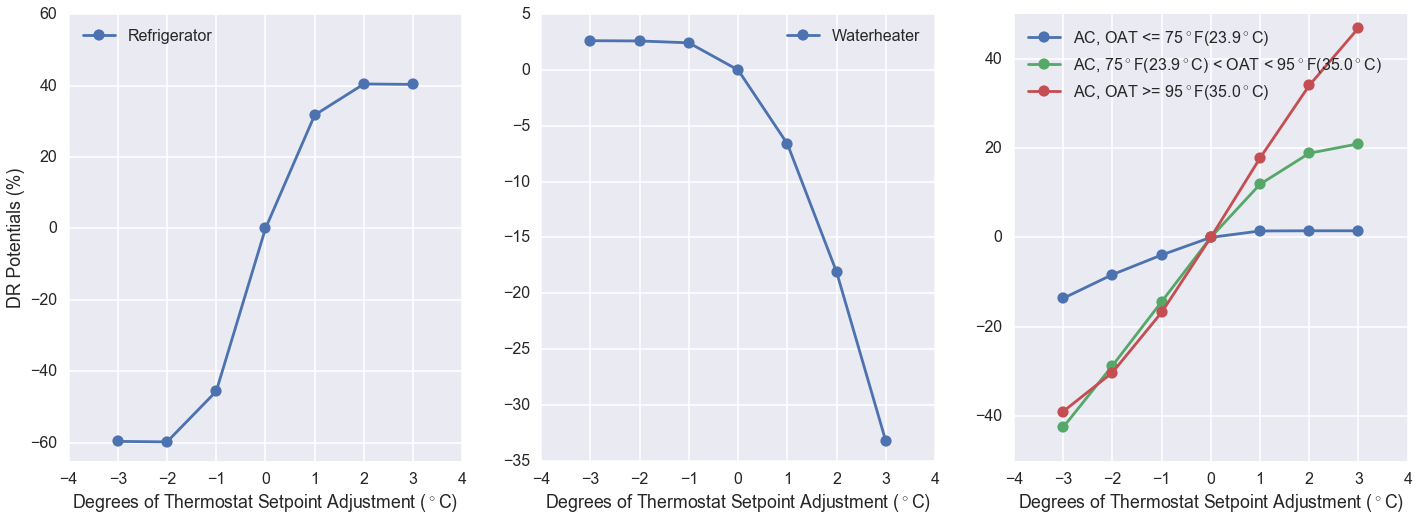

In [58]:
sns.set_context('poster')
temps=[-3,-2,-1,0,1,2,3]
GroupResults['AmbientTempF']=GroupResults.apply(FFromCelsius,axis=1)
GroupResults['DRPercent']=GroupResults.apply(GetDRPercent,axis=1)

#GroupResults2=GroupResults[GroupResults['SetPointChange']==2]
GroupResultsAll=GroupResults[['AmbientTempF','DRPercent','Type','SetPointChange']]

# GET THE AC RESULTS
DRPercentHourlyOATResults=pd.read_pickle('ACSetPointOATMultiDay.pkl')
DRPercentHourlyOATResults['Type']='AC'
DRPercentHourlyOATResults['DRPercent']=DRPercentHourlyOATResults['DRPercent']*-1
DRPercentHourlyOATResults['AmbientTempF']=DRPercentHourlyOATResults.apply(FFromCelsius,axis=1)

FromACs=DRPercentHourlyOATResults[['AmbientTempF','DRPercent','Type','SetPointChange']]

GroupResultsAll=pd.concat([FromACs,GroupResultsAll])

i=0
fig,axes=plt.subplots(1,3,figsize=[24,8])
Types=['Refrigerator','Waterheater','AC']

for typ in Types:
    DRPercentHourlyOATResults=GroupResultsAll[GroupResultsAll['Type']==typ]
    print('This is the type'+typ)
    if i<2:
        Tset1=[]
        # 1 and -1 degrees reset
        for elem in temps:
            if (elem == 0):
                Tset1.append(0)
            else:        
                y1 = DRPercentHourlyOATResults.loc[(DRPercentHourlyOATResults.SetPointChange == elem), ['AmbientTempF','DRPercent']].DRPercent
                Tset1.append(y1.mean())
        #print(Tset1)   
        #print(len(temps),len(Tset1))
        axes.ravel()[i].plot(temps,Tset1, 'o-', label = typ)
        #axes[i].set_title(str(i)+':00'+'~'+str(i+1)+':00',color='red')
        axes.ravel()[i].set_xlim(-4,4)
        if i==0:
            axes.ravel()[i].set_ylabel('DR Potentials (%)')
            axes.ravel()[i].legend(loc='upper left')
            axes.ravel()[i].set_ylim(-65,60)

        else:
            axes.ravel()[i].legend(loc='upper right')


    
    else:
        Tset1=[]
        Tset2=[]
        Tset3=[]
        # 1 and -1 degrees reset
        for elem in temps:
            if (elem == 0):
                Tset1.append(0)
                Tset2.append(0)
                Tset3.append(0)
            else:        
                y1 = DRPercentHourlyOATResults.loc[ (DRPercentHourlyOATResults.AmbientTempF <= 75) & (DRPercentHourlyOATResults.SetPointChange == elem), ['AmbientTempF','DRPercent']].DRPercent
                y2 = DRPercentHourlyOATResults.loc[ (DRPercentHourlyOATResults.AmbientTempF >= 75) & (DRPercentHourlyOATResults.SetPointChange == elem) & (DRPercentHourlyOATResults.AmbientTempF <= 95), ['AmbientTempF','DRPercent']].DRPercent
                y3 = DRPercentHourlyOATResults.loc[ (DRPercentHourlyOATResults.AmbientTempF >= 95) & (DRPercentHourlyOATResults.SetPointChange == elem),['AmbientTempF','DRPercent']].DRPercent

                Tset1.append(y1.mean())
                Tset2.append(y2.mean())
                Tset3.append(y3.mean())
        #print(Tset1)   
        #print(len(temps),len(Tset1))
        axes.ravel()[i].plot(temps,Tset1, 'o-', label = 'AC, OAT <= 75$^\circ$F(23.9$^\circ$C)')
        axes.ravel()[i].plot(temps,Tset2, 'o-', label = 'AC, 75$^\circ$F(23.9$^\circ$C) < OAT < 95$^\circ$F(35.0$^\circ$C)')
        axes.ravel()[i].plot(temps,Tset3, 'o-', label = 'AC, OAT >= 95$^\circ$F(35.0$^\circ$C)')
        axes.ravel()[i].set_xlim(-4,4)
        #axes[i].set_title(str(i)+':00'+'~'+str(i+1)+':00',color='red')
    #axes.ravel()[i].set_ylabel('DR Potential (%)')
        axes.ravel()[i].legend(loc='upper left')
    axes.ravel()[i].set_xlabel('Degrees of Thermostat Setpoint Adjustment ($^\circ$C)')
    i=i+1
fig.savefig('TempAdjustAllTwoStates.png',dpi=400,bbox_inches='tight')